In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
# read in train, val, test dfs 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [3]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(train_df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(train_df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [4]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}

new_alph = list(new_alph_map.values())

# one-hot encode
#modified code from Luis to get correct format for TPOT w/ my alphabet
one = One_Hot_Encoder(''.join(new_alph))
    
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq)                         
    encoded_seq = np.argmax((one_hot_seq), axis=1) 
    return encoded_seq
    #return pd.get_dummies(
      #list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# now convert the data into one_hot_encoding 
input_col_name = 'Encoded Seqs'
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
#val_data = np.stack(
    #[_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)

In [5]:
alph_len = len(new_alph)

from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [6]:
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD

def embed_model(embed_dim, hidden_layers):
    X_in = Input(shape=(seq_len,),dtype='float32')
    E = Embedding(alph_len,embed_dim,input_length=seq_len)(X_in)
    H = Flatten()(E)
    for h in hidden_layers: 
        H = Dense(h, activation='relu')(H)
#     H = Dense(1,activation="sigmoid",name='preds')(H)
    H = Dense(2,activation="softmax",name='preds')(H)
    model = Model(inputs=[X_in], outputs=H)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])#[precision,recall])#metrics=[sensitivity, specificity])
    return model

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define k-fold cross validation test harness
num_folds = 3
num_epochs = 20
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
all_scores = {}
X = train_data
y = train_bins


embed_dims = [3,5]
hidden_layer_choices = [(50,10), (50,), (30,)]

for embed_dim in embed_dims: 
    for hidden_layers in hidden_layer_choices: 
        param_combo = (embed_dim, hidden_layers)
        cvscores = []
        for train, test in kfold.split(X, y.argmax(1)):
          # create model
            model = embed_model(embed_dim = embed_dim, hidden_layers=hidden_layers)
            #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='auto', baseline=None)
            model.fit(X[train], y[train],epochs=num_epochs, batch_size=128,verbose=0)#,callbacks=[early_stopping])
            # evaluate the model

            y_pred = model.predict(X[test])
            y_true = y[test]

            y_true_labels = np.argmax(y[test], axis=1)
            y_pred_labels = np.argmax(y_pred, axis=1) 

            average_precision = average_precision_score(y_true, y_pred)
            auc = roc_auc_score(y_true_labels, y_pred_labels)
            acc = sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels)
            f1_val = sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro')
            print('Average precision-recall score:', average_precision)
            print('AUC:', auc)
            print('Accuracy:', acc)
            print('F1:', f1_val)
            cvscores.append([average_precision, auc, acc, f1_val])
        all_scores[param_combo] = cvscores


Average precision-recall score: 0.8289504862312473
AUC: 0.774639406540683
Accuracy: 0.9987526025663368
F1: 0.8031558631166464
Average precision-recall score: 0.7859987451055784
AUC: 0.7405574556036961
Accuracy: 0.9985324601471208
F1: 0.7670743957876585
Average precision-recall score: 0.8250580308515802
AUC: 0.7944382249324787
Accuracy: 0.9986883742260949
F1: 0.8048486524432743
Average precision-recall score: 0.8406942064892109
AUC: 0.7668227559444355
Accuracy: 0.9987984627661038
F1: 0.8041767654363187
Average precision-recall score: 0.8212905664052963
AUC: 0.7641682002416357
Accuracy: 0.9987159026287308
F1: 0.7950001087878853
Average precision-recall score: 0.83767926289696
AUC: 0.7551207404738703
Accuracy: 0.9988626461820683
F1: 0.8047466928069325
Average precision-recall score: 0.8360914299566943
AUC: 0.7381188257888954
Accuracy: 0.9988810111256845
F1: 0.7990619674904829
Average precision-recall score: 0.8162435232044589
AUC: 0.7537429371566594
Accuracy: 0.9987709353732137
F1: 0.7954

In [26]:
d = pd.DataFrame.from_dict(all_scores)
d.to_csv('embed_grid_search_all.csv')

In [27]:
cv_means = {k:sum(np.array(v)/num_folds) for k,v in all_scores.items()}

In [28]:
cv_means

{(3, (50, 10)): array([0.81333575, 0.76987836, 0.99865781, 0.79169297]),
 (3, (50,)): array([0.83322135, 0.76203723, 0.99879234, 0.80130786]),
 (3, (30,)): array([0.83230579, 0.75773853, 0.99881374, 0.80114378]),
 (5, (50, 10)): array([0.81230635, 0.76900575, 0.99857221, 0.7816994 ]),
 (5, (50,)): array([0.84174041, 0.7743455 , 0.99887183, 0.81445022]),
 (5, (30,)): array([0.84195979, 0.78652361, 0.99882903, 0.81612403])}

<BarContainer object of 6 artists>

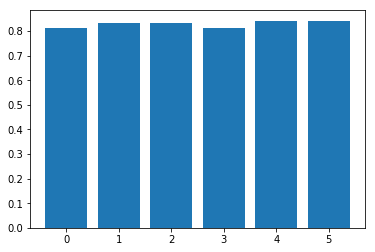

In [52]:
cv_means_df = pd.DataFrame.from_dict(cv_means)
param_combos = list(cv_means.keys())
score_vals = [cv_means[k][0] for k in param_combos]
plt.bar(range(len(param_combos)),score_vals)

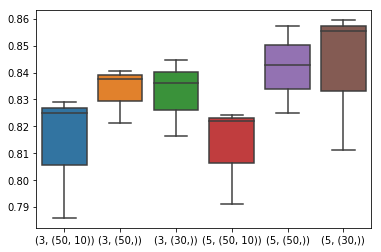

In [66]:
prec_recall_scores = []
for params in param_combos:
    folds = all_scores[params]
    prec_recall_scores.append([fold[0] for fold in folds])
param_combos_str = [str(params) for params in param_combos]
sns.boxplot(param_combos_str, prec_recall_scores)

In [ ]:
# best => embed_dim = 5, hidden_layers = (50,)